# 7.0 Baseline HAR-RV : configuration & imports

**Explication :**  
1) On met en place un script pour estimer le modèle "HAR-RV" (Corsi, 2009) sur le SPX et produire des prévisions à 1 jour et à 5 jours.  
3) On définit les constantes et les dossiers

**Pourquoi nous avons fait cela :**  
1) Le modèle HAR-RV sert de "baseline robuste" pour la prévision de volatilité réalisée, complémentaire à EWM et LSTM.  
2) Centraliser les chemins/constantes dès le début rend le script reproductible et facile à exécuter dans différents environnements.  


In [2]:

from __future__ import annotations
from pathlib import Path
import json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252
PROC_DIR = Path("data/processed")
OUT_DIR  = Path("data/models/har_rv")
OUT_DIR.mkdir(parents=True, exist_ok=True)


### 7.1 Fonction "load_base"

**Explication :**  
1) Lecture du fichier parquet contenant les features du SPX, triées par date.  
2) Calcul de la volatilité réalisée quotidienne en % annualisé à partir des rendements.  
3) Définition de la fonction interne "vol_k(k)" pour calculer la volatilité réalisée moyenne sur x jours, annualisée en %. (5 et 22 jours)
4) Construction des cibles :  
   - "target_sigma1" : volatilité au jour suivant.  
   - "target_vol5f" : volatilité moyenne future sur 5 jours.  
5) Assemblage du DataFrame final.
6) Nettoyage avec suppression des NaN et réindexation.  

**Pourquoi nous avons fait cela :**  
1) Avoir un jeu de données cohérent et prêt pour l’entraînement/test du modèle HAR-RV.  
2) Comparer différentes granularités de volatilité réalisée (jours , semaines, mois) pour capturer la dynamique multi-échelles du marché.  
3) Construire des cibles explicites qui permettront de tester la capacité du modèle à prédire le court terme et le moyen terme.  
4) Intégrer également la baseline EWM pour une comparaison directe avec HAR-RV et LSTM.  


In [3]:
def load_base():
    df = pd.read_parquet(PROC_DIR/"spx_index_features.parquet").sort_values("date").reset_index(drop=True)
    rv_d = np.sqrt(df["ret_d"].astype(float)**2)*np.sqrt(TRADING_DAYS)*100.0
    r2 = (df["ret_d"].astype(float)**2)
    def vol_k(k):  
        return (np.sqrt(r2.rolling(k).mean())*np.sqrt(TRADING_DAYS)*100.0)
    rv_w = vol_k(5); rv_m = vol_k(22)

    sig1 = (df["ret_d"].astype(float)**2).shift(-1).pow(0.5)*np.sqrt(TRADING_DAYS)*100.0
    fwd_mat = np.column_stack([df["ret_d"].astype(float).shift(-k).values for k in range(1,6)])
    mask = ~np.isnan(fwd_mat).any(axis=1)
    vol5 = np.full(len(df), np.nan, dtype=float)
    vol5[mask] = np.sqrt(np.mean(np.square(fwd_mat[mask]), axis=1))*np.sqrt(TRADING_DAYS)*100.0

    frame = pd.DataFrame({
        "date": df["date"].values,
        "rv_d": rv_d.values, "rv_w": rv_w.values, "rv_m": rv_m.values,
        "ewm": (df["vol_ewm_094"].astype(float)*100.0).values,
        "target_sigma1": sig1.values,
        "target_vol5f":  vol5
    }).dropna().reset_index(drop=True)
    return frame


### 7.2 Fonction "fit_har"

**Explication :**  
1) Initialise un modèle de régression linéaire.  
2) Entraîne le modèle sur les observations situées aux indices.  
3) Génère des prédictions sur les observations.  
4) Retourne :  
   - "pred" : les valeurs prédites,  
   - "model.coef_" : les coefficients des variables explicatives,  
   - "model.intercept_" : l’ordonnée à l’origine.  

**Pourquoi nous avons fait cela :**  
1) Implémenter le modèle HAR-RV en utilisant une régression linéaire simple.  
2) Capturer les relations entre volatilité réalisée passée (jours , semaines, mois) et volatilité future.  
3) Obtenir à la fois les prédictions et les paramètres estimés.  


In [4]:
def fit_har(X, y, train_idx, test_idx):
    model = LinearRegression()
    model.fit(X[train_idx], y[train_idx])
    pred = model.predict(X[test_idx])
    return pred, model.coef_, float(model.intercept_)


### 7.3 Fonction "rolling_oos"

**Explication :**  
1) Prépare les données.
2) Met en place une boucle de rolling window sur environ 5 ans.  
   - Pour chaque fenêtre, entraîne le modèle HAR sur l’échantillon et prédit au temps.  
   - Stocke les prédictions, les indices et les coefficients estimés.  
3) Construit un DataFrame "out" avec tout les informations.
4) Construit un DataFrame "betas" contenant les coefficients estimés associés aux dates.  
5) Retourne à la fois "out" (prédictions hors-échantillon) et "betas" (évolution des coefficients).  

**Pourquoi nous avons fait cela :**  
1) Évaluer le modèle HAR-RV en vraie prévision hors-échantillon avec une fenêtre roulante, plutôt qu’en in-sample.  
2) Capturer la stabilité ou variabilité des coefficients au cours du temps, indicateur de robustesse du modèle.  
3) Permettre une comparaison directe entre HAR-RV et la baseline EWM en termes de précision prédictive.  
4) Reproduire une pratique réaliste de prévision en finance : recalibrer régulièrement le modèle sur les données récentes.  


In [5]:
def rolling_oos(df, target_col, lookback=1260):  
    y = df[target_col].values
    X = df[["rv_d","rv_w","rv_m"]].values
    dates = df["date"].values
    preds, idxs = [], []
    coefs = []
    for t in range(lookback, len(df)):
        tr = slice(t-lookback, t)   
        te = [t]
        p, coef, intercept = fit_har(X, y, np.arange(tr.start, tr.stop), te)
        preds.append(p[0]); idxs.append(t); coefs.append((intercept, *coef))
    out = pd.DataFrame({
        "date": dates[idxs],
        "y_true": y[idxs],
        "y_pred_har": preds,
        "ewm": df["ewm"].values[idxs]
    })
    coefs = np.array(coefs)
    betas = pd.DataFrame(coefs, columns=["alpha","beta_d","beta_w","beta_m"])
    betas["date"] = dates[idxs]
    return out, betas


### 7.4 Fonction "metrics"

**Explication :**  
1) Extrait les valeurs réelles (y_true) et les valeurs prédites (pred_col) depuis le DataFrame.  
2) Calcule la RMSE (racine de l’erreur quadratique moyenne).  
3) Calcule la MAE (moyenne de l’erreur absolue).  
4) Retourne les deux métriques.  

**Pourquoi nous avons fait cela :**  
1) Fournir des indicateurs standards pour évaluer la qualité des prévisions de volatilité.  
2) RMSE pénalise davantage les grosses erreurs, alors que MAE donne une mesure plus robuste et intuitive.  
3) Permettre de comparer objectivement les modèles (HAR-RV, EWM, LSTM) sur la base des mêmes critères.  


In [6]:
def metrics(df, pred_col):
    y = df["y_true"].values; p = df[pred_col].values
    rmse = float(np.sqrt(np.mean((p-y)**2)))
    mae  = float(np.mean(np.abs(p-y)))
    return rmse, mae


### 7.5 Fonction "main

**Explication :**  
1) Effectue les prévisions hors-échantillon :    
3) Évalue les performances avec les métriques RMSE** et MAE, pour HAR-RV et EWM.  
4) Sauvegarde les résultats (Prévisions, Coefficients estimés et Résumé des métriques)
5) Génère et sauvegarde des graphiques comparant HAR-RV et EWM dans le temps.  
6) Affiche un résumé des performances directement dans la console.  

**Pourquoi nous avons fait cela :**  
1) Fournir une évaluation complète du modèle HAR-RV sur deux horizons (1 jour et 5 jours).  
2) Comparer systématiquement HAR-RV avec la baseline EWM pour juger de la valeur ajoutée.  


In [7]:
def main():
    df = load_base()
    o1, b1 = rolling_oos(df, "target_sigma1", lookback=1260)
    rmse_h1, mae_h1 = metrics(o1, "y_pred_har")
    rmse_e1, mae_e1 = metrics(o1, "ewm")
    o5, b5 = rolling_oos(df, "target_vol5f", lookback=1260)
    rmse_h5, mae_h5 = metrics(o5, "y_pred_har")
    rmse_e5, mae_e5 = metrics(o5, "ewm")

    o1.to_csv(OUT_DIR/"har_sigma1_test.csv", index=False)
    o5.to_csv(OUT_DIR/"har_vol5f_test.csv", index=False)
    b1.to_csv(OUT_DIR/"har_sigma1_betas.csv", index=False)
    b5.to_csv(OUT_DIR/"har_vol5f_betas.csv", index=False)

    met = {
        "sigma1": {"har_rmse": rmse_h1, "har_mae": mae_h1, "ewm_rmse": rmse_e1, "ewm_mae": mae_e1},
        "vol5f":  {"har_rmse": rmse_h5, "har_mae": mae_h5, "ewm_rmse": rmse_e5, "ewm_mae": mae_e5}
    }
    Path(OUT_DIR/"metrics.json").write_text(json.dumps(met, indent=2), encoding="utf-8")

    for name, o in [("sigma1", o1), ("vol5f", o5)]:
        plt.figure(figsize=(12,5))
        plt.plot(o["date"], o["y_true"], label="Target", alpha=0.8)
        plt.plot(o["date"], o["ewm"], label="EWM λ=0.94", alpha=0.8)
        plt.plot(o["date"], o["y_pred_har"], label="HAR-RV", alpha=0.9)
        plt.title(f"HAR-RV vs EWM — {name}")
        plt.legend(); plt.tight_layout()
        plt.savefig(OUT_DIR/f"har_{name}_vs_ewm.png", dpi=150); plt.close()

    print("HAR-RV — σₜ₊₁  : RMSE {:.3f} | MAE {:.3f}  (EWM RMSE {:.3f} | MAE {:.3f})".format(
        rmse_h1, mae_h1, rmse_e1, mae_e1))
    print("HAR-RV — vol5f : RMSE {:.3f} | MAE {:.3f}  (EWM RMSE {:.3f} | MAE {:.3f})".format(
        rmse_h5, mae_h5, rmse_e5, mae_e5))

if __name__ == "__main__":
    main()

HAR-RV — σₜ₊₁  : RMSE 12.656 | MAE 8.672  (EWM RMSE 13.407 | MAE 9.839)
HAR-RV — vol5f : RMSE 7.927 | MAE 5.259  (EWM RMSE 8.328 | MAE 5.546)


### 7.6 Inspection des résultats HAR-RV sauvegardés

**Explication :**  
1) Charge les résultats de test si disponibles ( prévision jours 1 & 5) et affiche les premières lignes du DataFrame  
4) Charge et affiche le contenu du fichier "metrics.json".  

**Pourquoi nous avons fait cela :**  
1) Vérifier que le pipeline HAR-RV a bien produit tous les fichiers attendus.  
2) Avoir un aperçu rapide des prévisions sauvegardées afin de confirmer la cohérence des sorties.  
3) Consulter les métriques finales (RMSE, MAE pour HAR-RV et EWM).  


In [8]:


out = Path("data/models/har_rv")
print(sorted(p.name for p in out.glob("*")))

df1 = pd.read_csv(out/"har_sigma1_test.csv", parse_dates=["date"]) if (out/"har_sigma1_test.csv").exists() else None
df5 = pd.read_csv(out/"har_vol5f_test.csv", parse_dates=["date"]) if (out/"har_vol5f_test.csv").exists() else None
if df1 is not None: display(df1.head())
if df5 is not None: display(df5.head())

if (out/"metrics.json").exists():
    print(json.loads((out/"metrics.json").read_text(encoding="utf-8")))


['har_sigma1_betas.csv', 'har_sigma1_test.csv', 'har_sigma1_vs_ewm.png', 'har_vol5f_betas.csv', 'har_vol5f_test.csv', 'har_vol5f_vs_ewm.png', 'metrics.json']


,date,y_true,y_pred_har,ewm
0,1998-05-27,7.785646,9.657803,12.326749
1,1998-05-28,9.836318,9.108532,12.102429
2,1998-05-29,0.232878,9.306887,11.978558
3,1998-06-01,3.255998,8.851472,11.613783
4,1998-06-02,15.305933,7.532607,11.288191


,date,y_true,y_pred_har,ewm
0,1998-05-27,8.969914,11.579505,12.326749
1,1998-05-28,11.427358,11.023166,12.102429
2,1998-05-29,16.152377,11.249531,11.978558
3,1998-06-01,16.195415,10.679732,11.613783
4,1998-06-02,16.220171,9.389883,11.288191


{'sigma1': {'har_rmse': 12.65626098091, 'har_mae': 8.672425566098196, 'ewm_rmse': 13.406537294918113, 'ewm_mae': 9.83933847248284}, 'vol5f': {'har_rmse': 7.926629436981201, 'har_mae': 5.258936167542989, 'ewm_rmse': 8.32849985253082, 'ewm_mae': 5.5457865261948305}}


### 7.8 Graphique 

**Graphique 1:**
- Les deux modèles (HAR-RV et EWM) suivent assez bien la dynamique générale de la volatilité réalisée.
- HAR-RV capture mieux certains pics extrêmes (crises 2008, 2020, 2025) que l’EWM, qui tend à lisser davantage.
- Sur les périodes calmes, HAR-RV et EWM sont quasiment superposés → pas de gain majeur en régime stable.

**Graphique 2:**
- Les deux modèles sont extrêmement proches → peu de différence visuelle.
- HAR-RV conserve un léger avantage dans la réactivité aux hausses de volatilité, mais l’écart reste minime.
- Sur des horizons de 5 jours, EWM λ=0.94 est déjà un bon lisseur, expliquant la proximité avec HAR-RV.



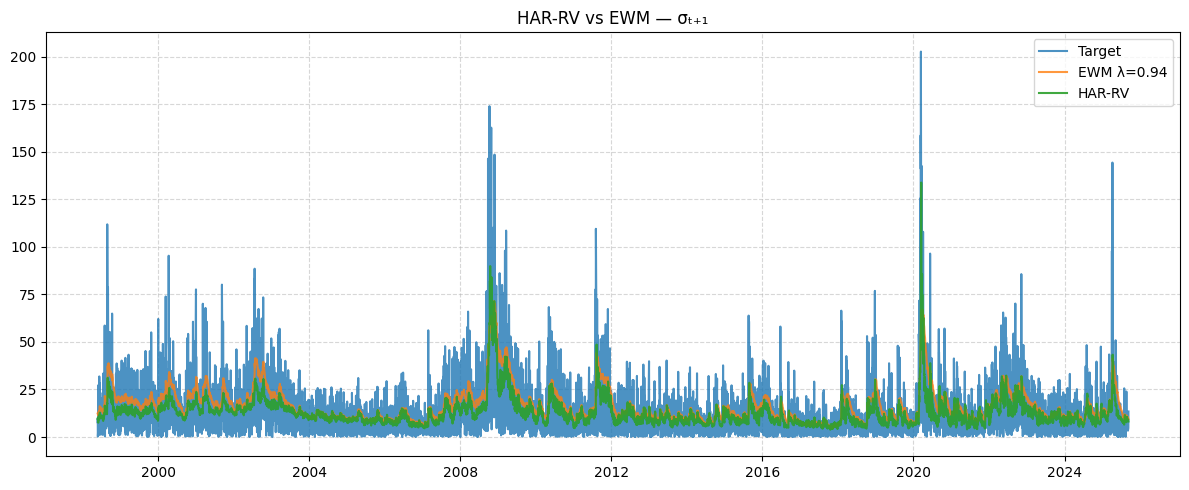

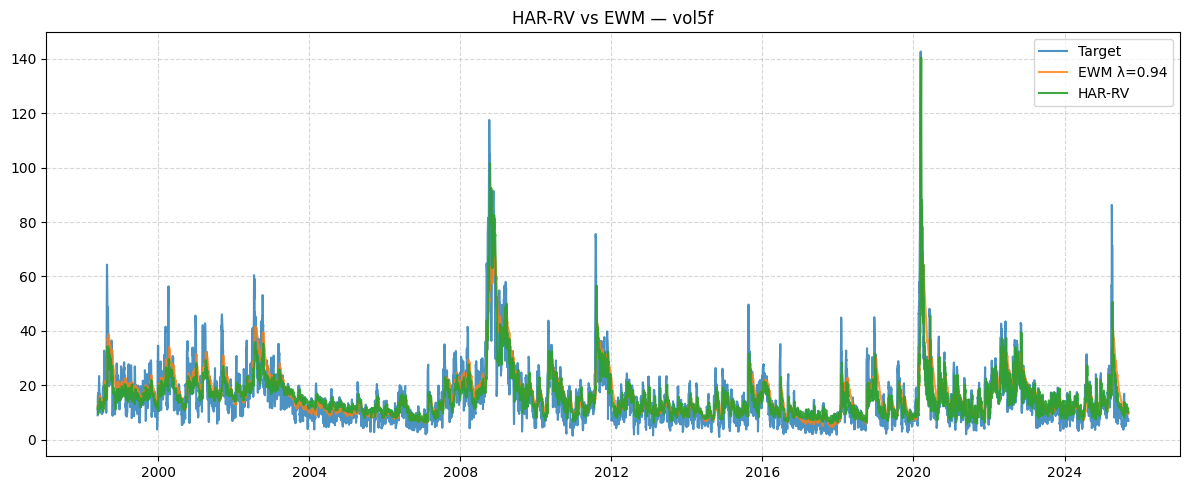

In [9]:
def show_har_plots(out_dir: str | Path = "data/models/har_rv"):
    """
    Affiche les graphiques HAR-RV vs EWM pour sigma1 et vol5f
    à partir des CSV générés dans out_dir.
    """
    out_dir = Path(out_dir)

    # --- sigma1 ---
    f1 = out_dir / "har_sigma1_test.csv"
    if f1.exists():
        df1 = pd.read_csv(f1, parse_dates=["date"])
        plt.figure(figsize=(12, 5))
        plt.plot(df1["date"], df1["y_true"], label="Target", alpha=0.8)
        plt.plot(df1["date"], df1["ewm"], label="EWM λ=0.94", alpha=0.8)
        plt.plot(df1["date"], df1["y_pred_har"], label="HAR-RV", alpha=0.9)
        plt.title("HAR-RV vs EWM — σₜ₊₁")
        plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout(); plt.show()
    else:
        print("⚠️ Fichier har_sigma1_test.csv introuvable.")

    # --- vol5f ---
    f5 = out_dir / "har_vol5f_test.csv"
    if f5.exists():
        df5 = pd.read_csv(f5, parse_dates=["date"])
        plt.figure(figsize=(12, 5))
        plt.plot(df5["date"], df5["y_true"], label="Target", alpha=0.8)
        plt.plot(df5["date"], df5["ewm"], label="EWM λ=0.94", alpha=0.8)
        plt.plot(df5["date"], df5["y_pred_har"], label="HAR-RV", alpha=0.9)
        plt.title("HAR-RV vs EWM — vol5f")
        plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout(); plt.show()
    else:
        print("⚠️ Fichier har_vol5f_test.csv introuvable.")

show_har_plots()
